In [55]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
import nilearn
from tree_features import connectome_average, matrix_fusion, tree_connectivity, tree_modules, level_dictionary, level_from_tree
from tree_features import T_from_level, adj_matrices_from_level, brain_maps_network_measures, threshold_based_similarity_external
from tree_features import tree_dictionary, get_module_vol, cross_modularity, add_gamma_to_lvl_dict, threshold_based_similarity, modularity, network_from_level, network_measures
from io_functions import load_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
import networkx as nx




### Generate population-tree features for each given tree span and gamma parameter

In [4]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))

In [5]:
fcm, scm = connectome_average(fc_group, sc_group)

### Generate trees based on minimum and maximum levels

In [7]:
tree_folder = "tree_network_measures"
tree_min = 3
tree_max = 100

for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm, scm)
    t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")
    json.dump(t_dict, open(os.path.join(project_path, "df_connectomes", "tree_network_measures", "tree_features_g_" + str(round(g, 2)) + ".json"), "w"))

In [80]:
lvlmin = 3
lvlmax = 30
crossmod_gammas = np.empty((lvlmax - lvlmin, 1))
mod_sc_gammas = np.empty((lvlmax - lvlmin, 1))
mod_fc_gammas = np.empty((lvlmax - lvlmin, 1))
sim_gammas = np.empty((lvlmax - lvlmin, 1))
thrs_tree = {}
for g in np.arange(0, 1.1, 0.1):
    tree = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_network_measures",
        "tree_features_g_" + str(round(g, 2)) + ".json")).read())
    crossmod = []
    mod_sc = []
    mod_fc = []
    sim_lvl = []
    for l in range(lvlmin,lvlmax):
        level, labels = level_from_tree(tree, l)
        c, thrs = cross_modularity(fcm, scm, level, labels)
        thrs_tree.update(add_gamma_to_lvl_dict(thrs, g))
        sim, _ = threshold_based_similarity(fcm, scm, level, labels)
        T = T_from_level(level)
        crossmod.append(c)
        mod_sc.append(modularity(scm, T))
        mod_fc.append(modularity(fcm, T))
        sim_lvl.append(np.mean(sim))
    crossmod_gammas = np.hstack((crossmod_gammas, np.array(crossmod).reshape(-1,1)))
    mod_sc_gammas = np.hstack((mod_sc_gammas, np.array(mod_sc).reshape(-1,1)))
    mod_fc_gammas = np.hstack((mod_fc_gammas, np.array(mod_fc).reshape(-1,1)))
    sim_gammas = np.hstack((sim_gammas, np.array(sim_lvl).reshape(-1,1)))


/home/antoniojm/Documents/projects/git-pipelines/bha2/bha/tree_features.py:189: RuntimeWarning: invalid value encountered in double_scalars
  level, labels = level_from_tree(tree, lv)


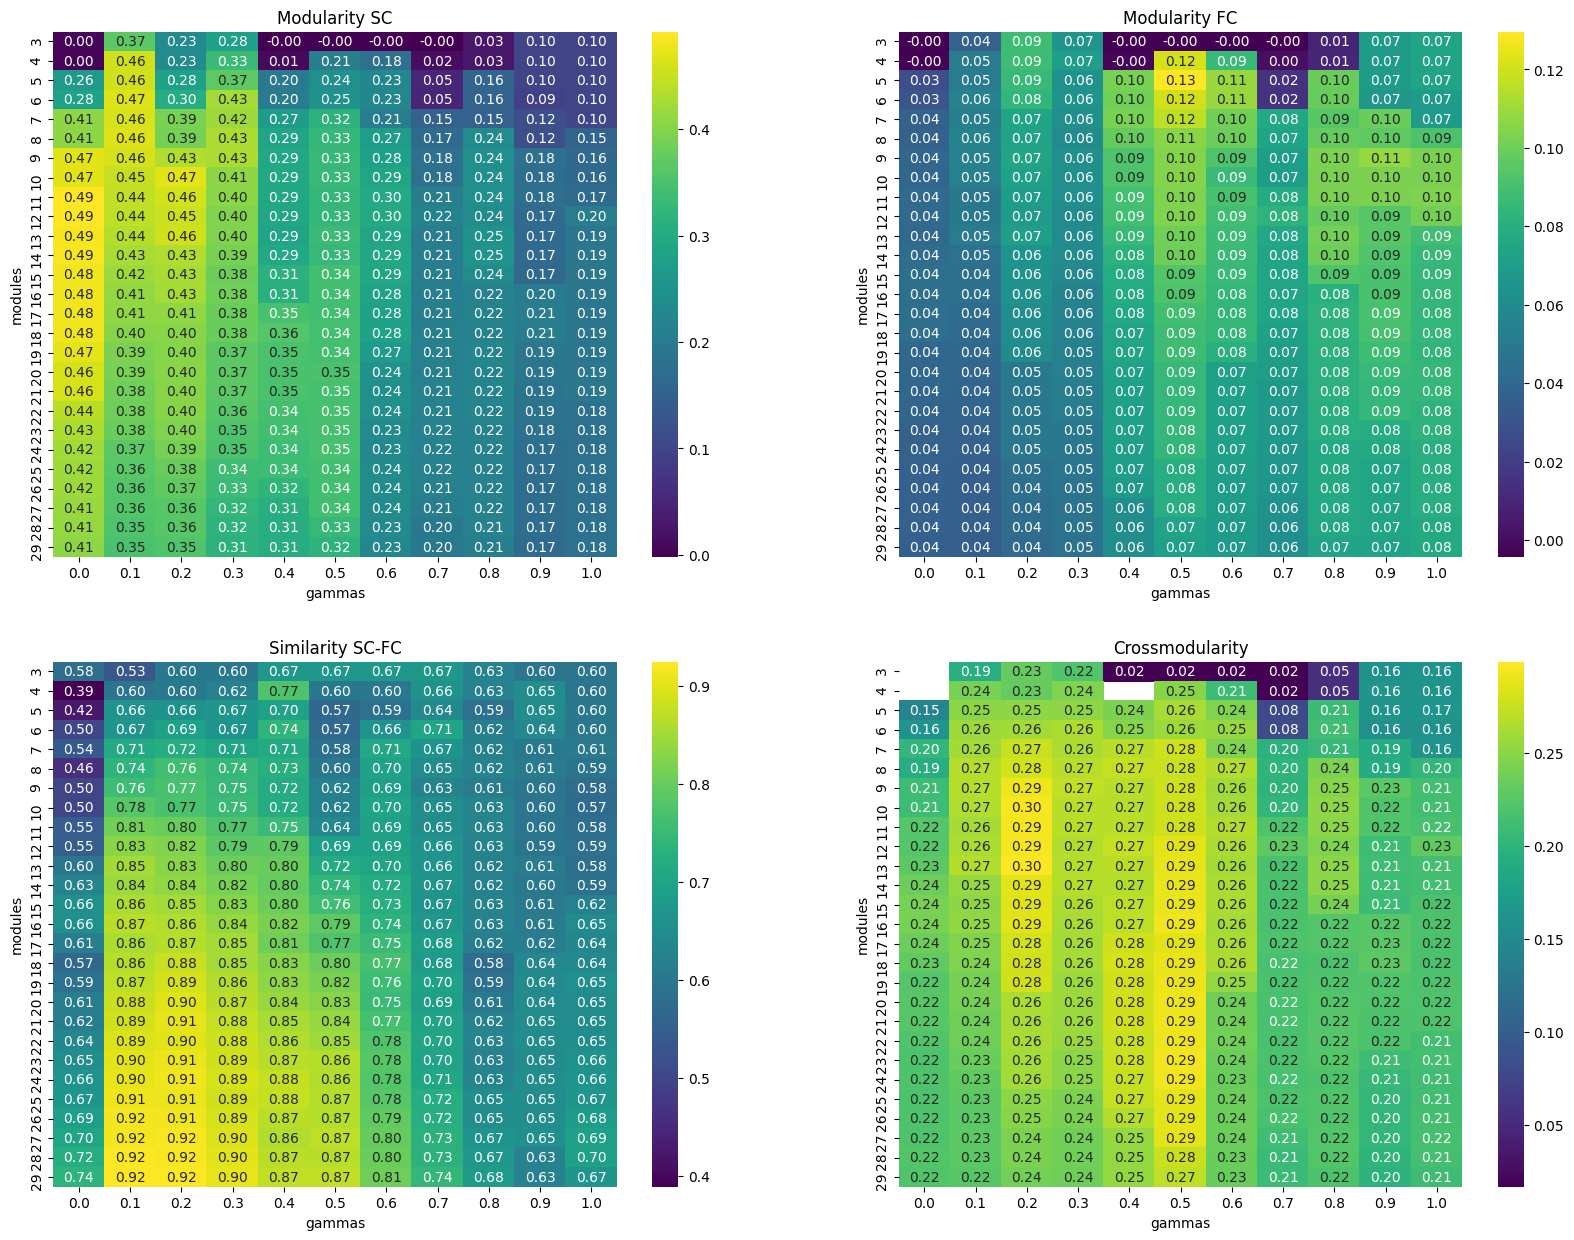

In [101]:
plot, axes = plt.subplots(2, 2, figsize=(20, 15))

h1 = sns.heatmap(mod_sc_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[0,0])
_ = h1.set(xlabel='gammas', ylabel='modules')
_ = h1.set_title("Modularity SC")

h2 = sns.heatmap(mod_fc_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[0,1])
_ = h2.set(xlabel='gammas', ylabel='modules')
_ = h2.set_title("Modularity FC")

h3 = sns.heatmap(sim_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[1,0])
_ = h3.set(xlabel='gammas', ylabel='modules')
_ = h3.set_title("Similarity SC-FC")

h4 = sns.heatmap(crossmod_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[1,1])
_ = h4.set(xlabel='gammas', ylabel='modules')
_ = h4.set_title("Crossmodularity")

'gamma_0.2_lvl_13_mod_'

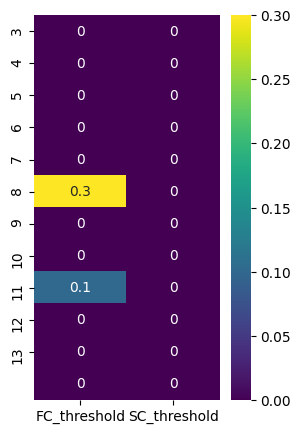

In [108]:
x,y = np.where(crossmod_gammas == np.nanmax(crossmod_gammas))
gammas_vec = np.arange(0, 1.1, 0.1)
levels_vec = np.arange(lvlmin, lvlmax)
key_pattern = "gamma_" + str(gammas_vec[y-1][0]) + "_lvl_" + str(levels_vec[x][0]) + "_mod_"
thresholds = [value for key,value in thrs_tree.items() if key.startswith(key_pattern)]
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(thresholds, cmap='viridis', annot=True, ax = ax,
    yticklabels=np.arange(lvlmin, levels_vec[x]+1),
    xticklabels = np.array(['FC_threshold', 'SC_threshold']))
key_pattern

In [ ]:
lvlmin = 3
lvlmax = 30


sim_gammas_ext = np.empty((lvlmax - lvlmin, 1))
thrs_tree = {}
for g in np.arange(0, 1.1, 0.1):
    tree = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_network_measures",
        "tree_features_g_" + str(round(g, 2)) + ".json")).read())
    sim_lvl_ext = []
    for l in range(lvlmin,lvlmax):
        level, labels = level_from_tree(tree, l)
        sim, thrs = threshold_based_similarity_external(fcm, scm, level, labels)
        thrs_tree.update(add_gamma_to_lvl_dict(thrs, g))
        sim_lvl_ext.append(np.mean(sim))
    sim_gammas_ext = np.hstack((sim_gammas_ext, np.array(sim_lvl_ext).reshape(-1,1)))


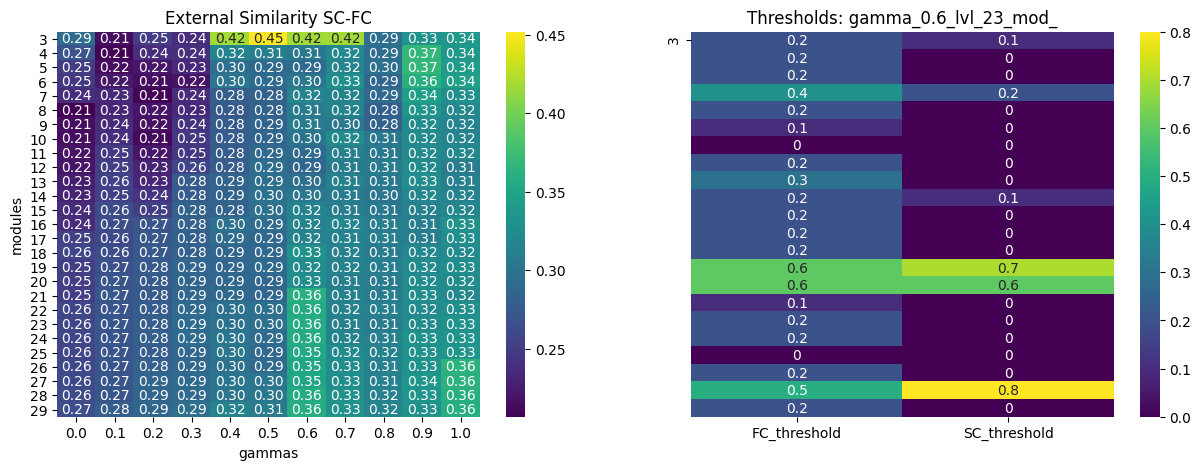

In [78]:
plot, axes = plt.subplots(1, 2, figsize=(15,5))

h1 = sns.heatmap(sim_gammas_ext[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[0])
_ = h1.set(xlabel='gammas', ylabel='modules')
_ = h1.set_title("External Similarity SC-FC")

x,y = np.where(sim_gammas_ext == np.nanmax(sim_gammas_ext))
gammas_vec = np.arange(0, 1.1, 0.1)
levels_vec = np.arange(lvlmin, lvlmax)
#key_pattern = "gamma_" + str(gammas_vec[y-1][0]) + "_lvl_" + str(levels_vec[x][0]) + "_mod_"
key_pattern = "gamma_" + str(0.6) + "_lvl_" + str(23) + "_mod_"
thresholds = [value for key,value in thrs_tree.items() if key.startswith(key_pattern)]

h2 = sns.heatmap(thresholds, cmap='viridis', annot=True, ax=axes[1],
    yticklabels=np.arange(lvlmin, levels_vec[x]+1),
    xticklabels = np.array(['FC_threshold', 'SC_threshold']))
_ = h2.set_title("Thresholds: " + key_pattern)


In [ ]:
from nilearn import plotting

atlas_name = "craddock_2128_2mm.nii.gz"
atlas = nib.load(os.path.join(project_path, atlas_name))
g = 1
l = 12
W = matrix_fusion(g, fcm, scm)
T = tree_modules(W, l)
lvel = level_dictionary(T)
#filteredroi = scm[:,lvel["lvl_2_mod_2"]]
#filteredroi.sum()
for l in lvel:
    rois = lvel[l]
    mod_img = nib.Nifti1Image(get_module_vol(atlas, rois), affine=atlas.affine)
    plotting.plot_glass_brain(mod_img, title=l)

Accumulated Q across gamma

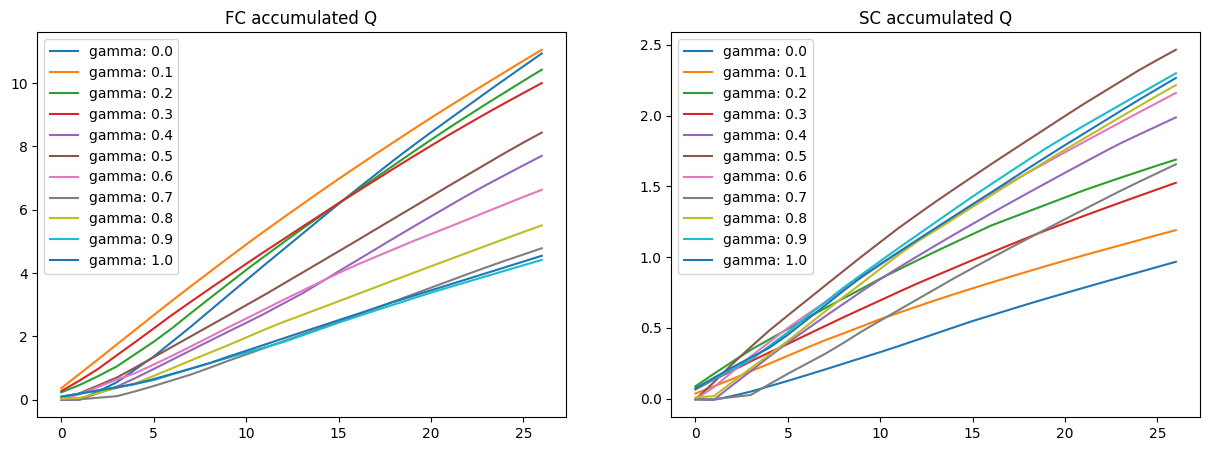

In [117]:
plot, axes = plt.subplots(1, 2, figsize=(15,5))

for idx, g in enumerate(np.arange(0, 1.1, 0.1)):
    axes[0].plot(np.cumsum(mod_sc_gammas[:,idx+1]), label="gamma: " + str(round(g, 2)))
    axes[1].plot(np.cumsum(mod_fc_gammas[:,idx+1]), label="gamma: " + str(round(g, 2)))
axes[0].legend()
axes[0].title.set_text('FC accumulated Q')
axes[1].legend()
axes[1].title.set_text('SC accumulated Q')

### Level network metrics

In [319]:
lv = 100
g = 0.5
tree = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_network_measures",
       "tree_features_g_" + str(round(g, 2)) + ".json")).read())
level, labels = level_from_tree(tree, lv)
sc_level, fc_level = adj_matrices_from_level(scm, fcm, level)
sc_level_net, fc_level_net = network_from_level(scm, fcm, level, labels)
n_meas = network_measures(fc_level_net)



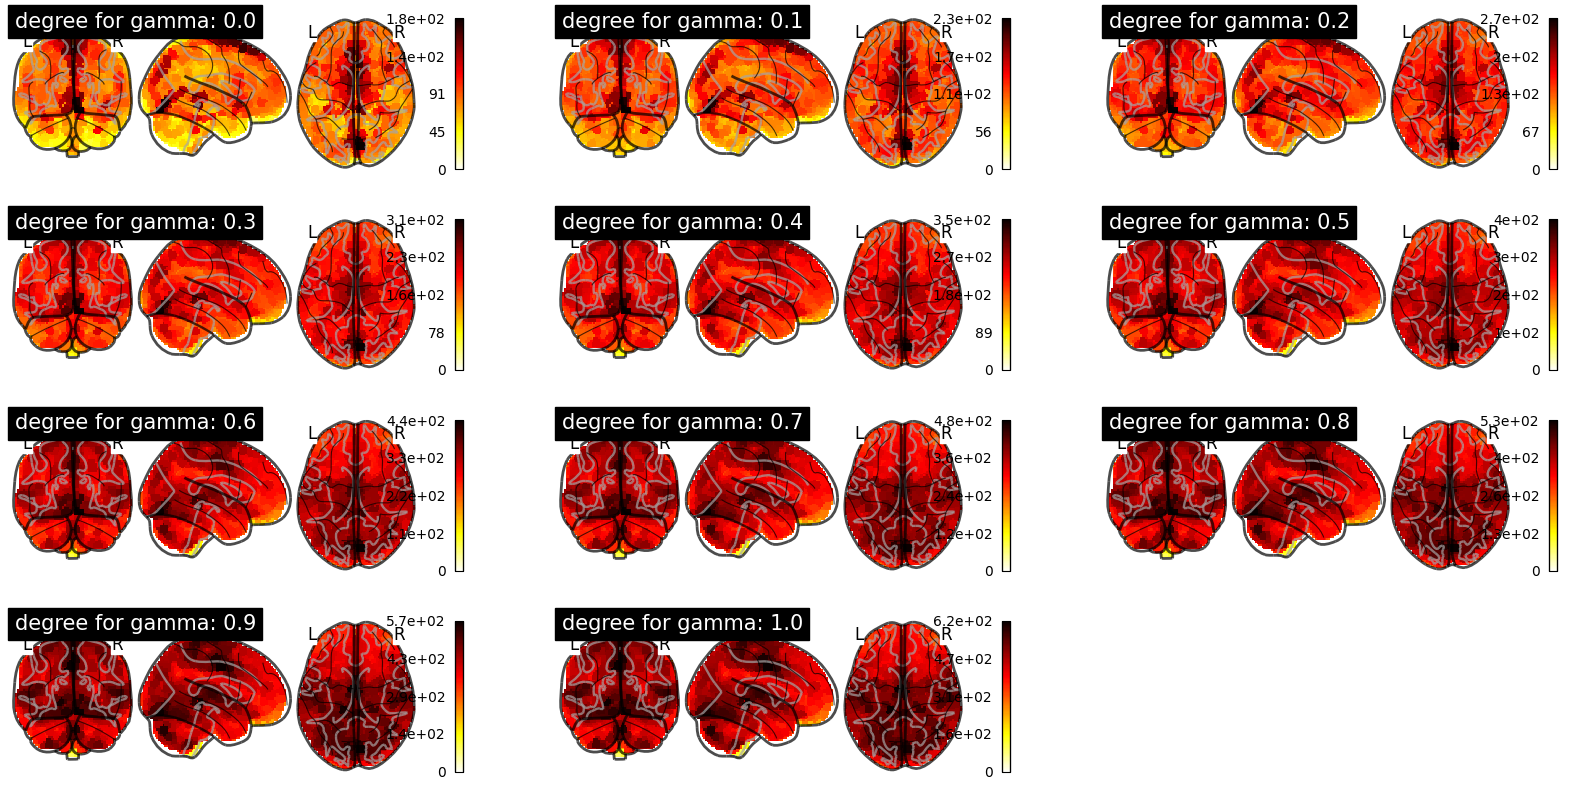

In [142]:
fig = plt.figure()    
for idx,g in enumerate(np.arange(0, 1.1, 0.1)):
    ax = fig.add_subplot(4, 3, idx+1)
    cc = np.multiply(((g * abs(fcm)) + ((1 - g) * scm)), np.sign(fcm))
    strength_fullmat = cc.sum(axis=0, dtype=float)
    atlas_name = "craddock_2128_2mm.nii.gz"
    atlas = nib.load(os.path.join(project_path, atlas_name))
    atlas_data = atlas.get_fdata()
    deg_img = np.zeros(atlas_data.shape)
    for roi in range(1,int(atlas_data.max())+1):
        deg_img[atlas_data == roi] = strength_fullmat[roi-1]
    
    plotting.plot_glass_brain(nib.Nifti1Image(deg_img, affine=atlas.affine), 
        colorbar=True, title="degree for gamma: " + str(round(g, 2)), axes=ax)

In [ ]:
for g in np.arange(0, 1.1, 0.1):
    tree = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_network_measures",
        "tree_features_g_" + str(round(g, 2)) + ".json")).read())
    atlas_name = "craddock_2128_2mm.nii.gz"
    atlas = nib.load(os.path.join(project_path, atlas_name))

    sc_meas_maps, fc_meas_maps = brain_maps_network_measures(tree, scm, fcm, atlas, range(3, 101))

    figure, ax = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))
    measures = ['Strength', 'Betweenness Centrality', 'Clustering Coefficient', 'Path Length']
    for i in range(4):
        netw_img_sc = nib.Nifti1Image(sc_meas_maps[i], affine=atlas.affine)
        netw_img_fc = nib.Nifti1Image(fc_meas_maps[i], affine=atlas.affine)
        figure = plotting.plot_glass_brain(netw_img_sc, title="SC " + measures[i], colorbar=True, axes=ax[i,0])
        figure = plotting.plot_glass_brain(netw_img_fc, title="FC " + measures[i], colorbar=True, axes=ax[i,1])
    figure.savefig(os.path.join(project_path, "df_connectomes", "network_measures_g_" + str(round(g, 2)) + ".png"))


## Extract features from lifespan data

In [3]:
from tree_features import tree_connectivity_fc
connectomes_path = "/home/antoniojm/Documents/projects/BHA_5G/lifespan"
trees_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon/df_connectomes"

sc_lifespan_group = load_data(os.path.join(connectomes_path, "sc"))
fc_lifespan_group = load_data(os.path.join(connectomes_path, "fc"))


In [11]:
import glob

files = sorted(glob.glob(connectomes_path + "/fc/*.csv"))
name = [(os.path.basename(x)).split('.')[0] for x in files]
pd.DataFrame(name).to_csv(os.path.join(connectomes_path, "list_sorted.txt"), index=False)

In [5]:

for g in np.arange(0.4, 1.1, 0.1):
    tree = json.loads(open(os.path.join(trees_path, 
        "tree_features_g_" + str(round(g, 2)) + ".json")).read())
    full_features = []
    for sc, fc in zip(sc_lifespan_group, fc_lifespan_group):
        t_features, t_features_names = tree_connectivity(tree, sc, fc)
        full_features.append(t_features)

    full_df = pd.DataFrame(full_features)
    full_df.columns = t_features_names
    full_df.to_csv(os.path.join(connectomes_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"), index=False)


/home/antoniojm/Documents/projects/git-pipelines/bha2/bha/tree_features.py:118: RuntimeWarning: Mean of empty slice
  fc_int = np.nanmean(fc[int_rois, :][:, int_rois], dtype=float)
/home/antoniojm/Documents/projects/git-pipelines/bha2/bha/tree_features.py:119: RuntimeWarning: Mean of empty slice
  fc_out = np.nanmean(fc[int_rois[:, None], ext_rois], dtype=float)


### Store a nifti of a given module

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import os
import json

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
t_dictionary = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_0.5.json"), "r").read())
rois = t_dictionary['lvl_20_mod_3']

atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))
atlas_data = atlas.get_fdata()
atlas_rois = np.where(atlas_data == (np.array(rois)+1), 1, 0).sum(axis=3)
atlas_rois_image = nib.Nifti1Image(atlas_rois, affine=atlas.affine)
nib.save(atlas_rois_image, os.path.join(project_path, "craddock_2128_2mm_lvl_20_mod_3.nii.gz"))


### Neuropsychological score prediction using population-tree features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nilearn import plotting
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV, RFE
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict, GridSearchCV
from scipy import stats
from reg_functions import get_mae_cv, univariate_feature_ranking, iterative_regression, optimal_brain_map
#from lightgbm import LGBMRegressor
#from xgboost import XGBRegressor
from scipy.stats import kruskal, pearsonr
import seaborn as sns


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/antoniojm/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## CVLT test (verbal memory)

(array([ 1.,  0.,  2.,  3., 13., 15., 21., 22., 33., 26.]),
 array([-7.5229775 , -6.47451775, -5.42605799, -4.37759824, -3.32913848,
        -2.28067873, -1.23221897, -0.18375922,  0.86470054,  1.91316029,
         2.96162005]),
 <BarContainer object of 10 artists>)

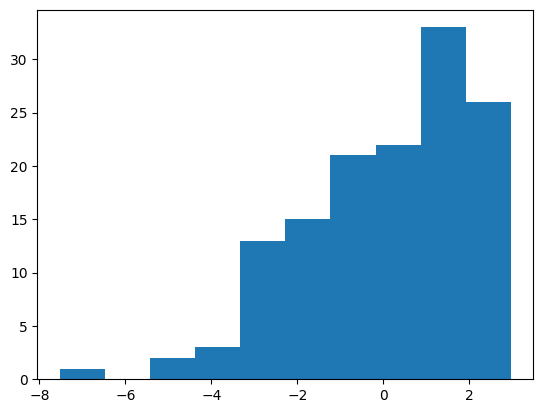

In [2]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
plt.hist(y)

#### Only training (cross-validation) using five different linear models

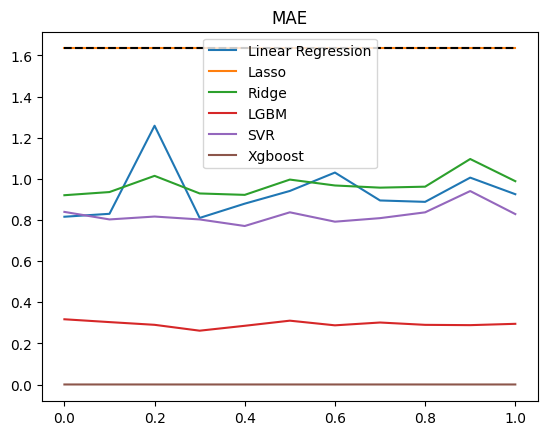

In [3]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
clf_1 = LinearRegression() 
clf_2 = Lasso() 
clf_3 = Ridge() 
clf_4 = LGBMRegressor()
clf_5 = SVR(kernel='linear') 
clf_6 = XGBRegressor()

list_clfs = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6]
clas_names = ['Linear Regression', 'Lasso', 'Ridge','LGBM', 'SVR', 'Xgboost']
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for idx,clf in enumerate(list_clfs):
    mae_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
        X = scaler.fit_transform(df)
        mae, mae_std = get_mae_cv(X, y, clf,5)
        mae_plot.append(mae)

    plt.plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    plt.title("MAE")

plt.legend()
mae_mean = np.mean(np.abs(y-np.mean(y)))

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 1], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

In [ ]:
g=0.3
scaler = StandardScaler()

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
features = scaler.fit_transform(df)
y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
# Explore relationship between each individual feature and age.
plt.figure(figsize=(20, 60))
valid_feat = []
for d in range (features.shape[1]):
    plt.subplot(21,5,d+1)
    plt.scatter(features[:,d],y,s=15)
    pearson_coeff, _ = pearsonr(features[:, d], y)
    if np.abs(pearson_coeff) > 0.15:
        valid_feat.append(d)
    plt.xlabel('Normalized volume')
    plt.ylabel('Age (years)')
    plt.xlim([-3.0, 3.0])
    plt.title(str(round(pearson_coeff, 2)))
plt.tight_layout()
plt.show()

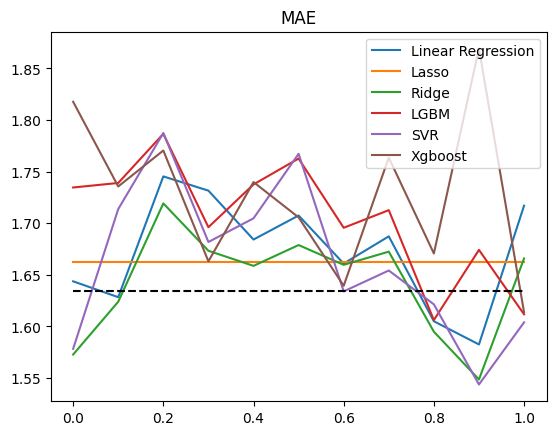

In [3]:
for idx,clf in enumerate(list_clfs):
    mae_plot = []
    for g in np.arange(0, 1.1, 0.1):
        df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
        X = scaler.fit_transform(df)
        valid_feat = []
        r_values = []
        for d in range (X.shape[1]):
            pearson_coeff, _ = pearsonr(X[:, d], y)
            if np.abs(pearson_coeff) > 0.15:
                valid_feat.append(d)
                r_values.append(pearson_coeff)
        good_features = X[:, valid_feat]
        mae, mae_std = get_mae_cv(good_features, y, clf, 5)
        mae_plot.append(mae)

    plt.plot(np.arange(0, 1.1, 0.1), mae_plot, label=clas_names[idx])
    plt.title("MAE")

plt.legend()

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 1], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

### Using SVR and rank

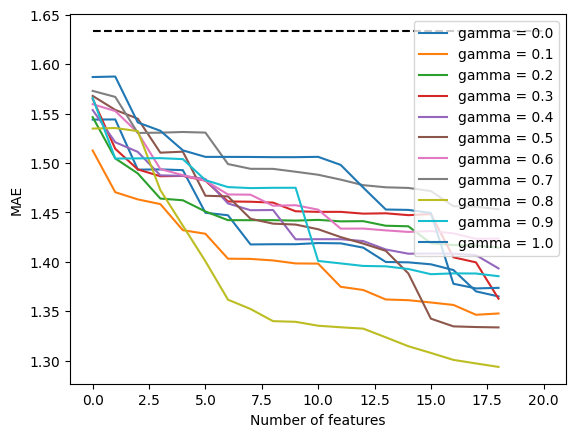

In [4]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"

y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for g in np.arange(0, 1.1, 0.1):
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, 20, clf_5, folds=5)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    #plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 20], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

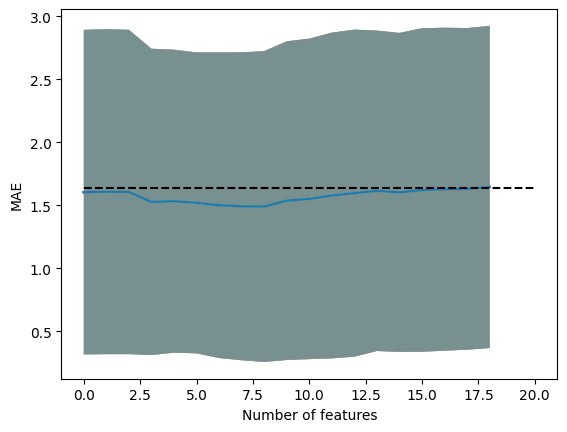

In [6]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"

y = np.genfromtxt(os.path.join(project_path, "behaviour", "Cognitive_Test_Battery_LEMON", 
    "CVLT",  "CVLT_zstuffed.txt"))
scaler = StandardScaler()

for g in np.arange(0, 1.1, 0.1):
    g = 0.8
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
    label_dict = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, 20, clf_5, folds=5)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, 20], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")

array([[1.        , 0.78673655],
       [0.78673655, 1.        ]])

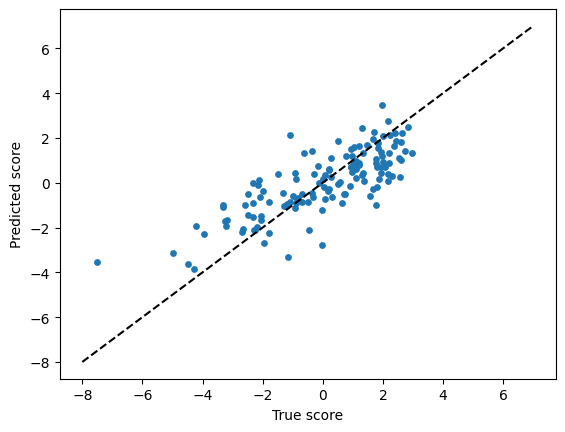

In [11]:
g = 0.8
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_10_20/tree_features_g_" + str(round(g, 2)) + ".csv"))
Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df, y)
#Y_pred = cross_val_predict(clf_3, Xsorted[:,:15], y, cv=5)
reg = clf_3.fit(Xsorted, y)
Y_pred = reg.predict(Xsorted)
plt.scatter(y, Y_pred, s=15)
plt.xlabel("True score")
plt.ylabel("Predicted score")
plt.plot(range(-8, 8), range(-8,8), color="black", linestyle="--")
np.corrcoef(y, Y_pred)

In [13]:
atlas_name = "craddock_2128_2mm.nii.gz"
brainmap = optimal_brain_map(project_path, atlas_name, names_sorted[:5], r_vals_sorted[:5], label_dict)
plotting.plot_glass_brain(brainmap, 
    colorbar = True, cmap='viridis')


KeyError: 'lvl_11_mod_2'

## Aging prediction using population-tree features

(array([14., 32., 18.,  5.,  8., 12.,  7., 20., 18., 13.]),
 array([10.887671 , 17.7989039, 24.7101368, 31.6213697, 38.5326026,
        45.4438355, 52.3550684, 59.2663013, 66.1775342, 73.0887671,
        80.       ]),
 <BarContainer object of 10 artists>)

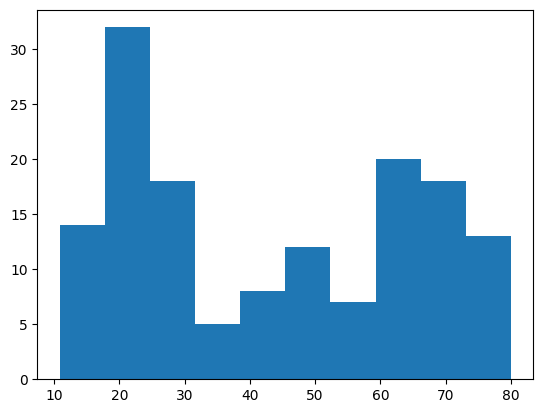

In [2]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lifespan"
y_df = pd.read_csv(os.path.join(project_path, "ages.csv"))


y = y_df["age"].values
labels = y_df["subject"].values

plt.hist(y)



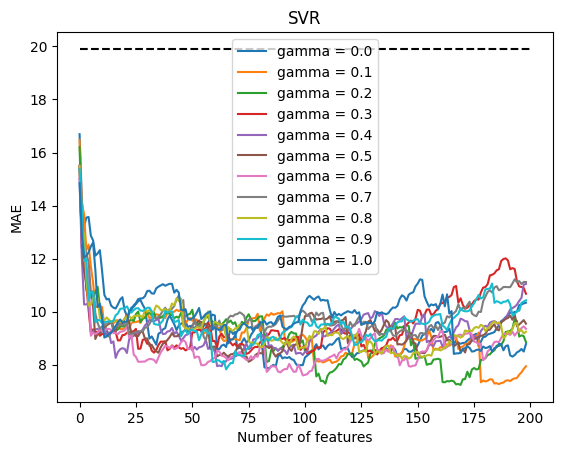

In [4]:

project_path = "/home/antoniojm/Documents/projects/BHA_5G/lifespan"
clf_1 = LinearRegression() 
clf_2 = Lasso() 
clf_3 = Ridge() 
#clf_4 = LGBMRegressor()
clf_5 = SVR(kernel='linear') 
#clf_6 = XGBRegressor()

#list_clfs = [clf_1, clf_2, clf_3, clf_4, clf_5, clf_6]
clas_names = ['Linear Regression', 'Lasso', 'Ridge','LGBM', 'SVR', 'Xgboost']
scaler = StandardScaler()


iterations = 200
for g in np.arange(0, 1.1, 0.1):
    df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
    df_nonans = df.dropna(axis=1, how='any')
    Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df_nonans, y)
    mae_mean, mae_std = iterative_regression(Xsorted, y, iterations, clf_5)

    plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
    #plt.fill_between(np.arange(0, 19), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
    plt.xlabel("Number of features")
    plt.ylabel("MAE")
    plt.title('SVR')
    plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, iterations], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")


8.301145718214723


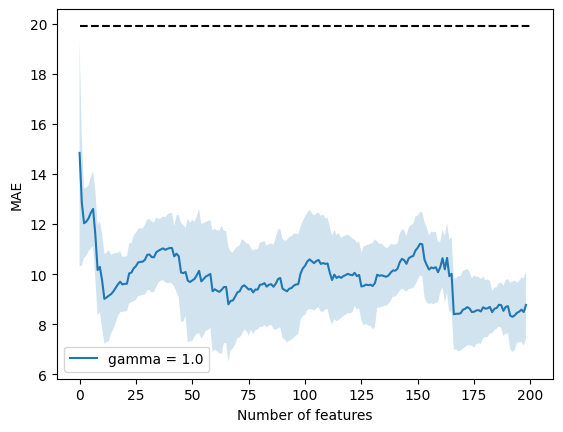

In [37]:
g = 1.0
df = pd.read_csv(os.path.join(project_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".csv"))
df_filtered = df.dropna(axis=1, how='any')

Xsorted, names_sorted, r_vals_sorted = univariate_feature_ranking(df_filtered, y)
mae_mean, mae_std = iterative_regression(Xsorted, y, iterations, clf_5)

plt.plot(mae_mean, label="gamma = " + str(round(g, 2)))
plt.fill_between(np.arange(0, iterations-1), np.array(mae_mean) - np.array(mae_std), np.array(mae_mean) + np.array(mae_std), alpha=0.2)
plt.xlabel("Number of features")
plt.ylabel("MAE")
plt.legend()  

mae_mean_y = np.mean(np.abs(y-np.mean(y)))
plt.plot([0, iterations], [mae_mean_y, mae_mean_y], label="Mean-std MAE", color="black", linestyle="--")


features_for_minmae = np.array(mae_mean).argmin()
print(np.array(mae_mean).min())

[-8.45461889 -6.67009857 -8.57246777 -9.77274962 -6.7681432 ]


array([[1.        , 0.88656888],
       [0.88656888, 1.        ]])

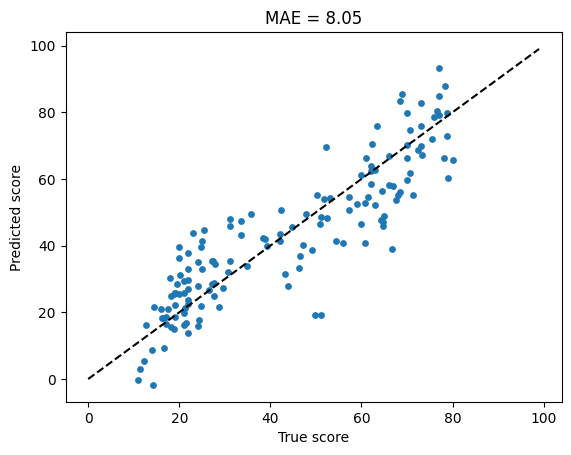

In [11]:
from sklearn.model_selection import cross_val_score

Y_pred = cross_val_predict(clf_5, Xsorted[:,:features_for_minmae], y, cv=5)
mae = mean_absolute_error(y, Y_pred)
scores = cross_val_score(clf_5, Xsorted[:,:features_for_minmae], y, scoring="neg_mean_absolute_error")
mae = -scores.mean()
plt.scatter(y, Y_pred, s=15)
plt.xlabel("True score")
plt.ylabel("Predicted score")
plt.title("MAE = " + str(round(mae, 2)))
plt.plot(range(0, 100), range(0,100), color="black", linestyle="--")
np.corrcoef(y, Y_pred)

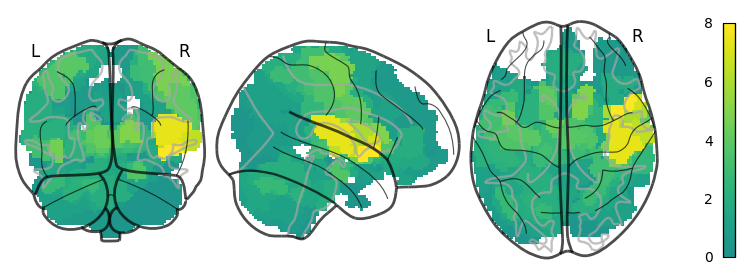

In [10]:
atlas_name = "craddock_2128_2mm.nii.gz"
tree_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
label_dict = json.loads(open(os.path.join(tree_path, "df_connectomes", "tree_features_g_" + str(round(g, 2)) + ".json"), "r").read())
brainmap = optimal_brain_map(tree_path, atlas_name, 
    names_sorted[:features_for_minmae], r_vals_sorted[:features_for_minmae], label_dict)
plotting.plot_glass_brain(brainmap, 
    colorbar = True, cmap='viridis')


In [23]:
best_features_names = names_sorted[:features_for_minmae]
sum('FCOUT' in s for s in best_features_names)


0

### Produce efficient LNM map

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import json
import os
from io_functions import load_data
from nilearn import plotting
from scipy.spatial.distance import dice

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/antoniojm/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
lesion_map = nib.load("/home/antoniojm/Documents/projects/NetwMAP_CCA/maps/lesion/PEL04.nii.gz")
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
t_dictionary = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_0.0.json"), "r").read())

atlas = nib.load(os.path.join(project_path, "craddock_2128_2mm.nii.gz"))

sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))



In [8]:
t_dictionary = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_features_g_1.0.json"), "r").read())

atlas_data = atlas.get_fdata()
sc_conn = []
fc_conn = []

for labels in t_dictionary:
    rois = np.array(t_dictionary[labels])
    lesion_data = lesion_map.get_fdata()
    module_mask = np.where(atlas_data == (np.array(rois)+1), 1, 0).sum(axis=3)
    overlap_with_lesion = np.sum(lesion_data * module_mask, dtype=float) / np.sum(module_mask, dtype=float)

    if overlap_with_lesion > 0.5:
        sc_conn.append(sc_group[:,rois,:].sum(axis=1, dtype = float).sum(axis=0, dtype = float))
        fc_conn.append(fc_group[:,rois,:].sum(axis=1, dtype = float).sum(axis=0, dtype = float))



In [9]:
sc_conn_mean = (np.array(sc_conn).sum(axis = 0,dtype = float))
fc_conn_mean = (np.array(fc_conn).sum(axis = 0,dtype = float))

In [10]:
fc_conn2atlas = np.zeros(atlas_data.shape)
sc_conn2atlas = np.zeros(atlas_data.shape)

for i in range(1,1+int(atlas_data.max())):
    fc_conn2atlas[np.where(atlas_data == np.array(i))] = fc_conn_mean[i-1]
    sc_conn2atlas[np.where(atlas_data == np.array(i))] = sc_conn_mean[i-1]

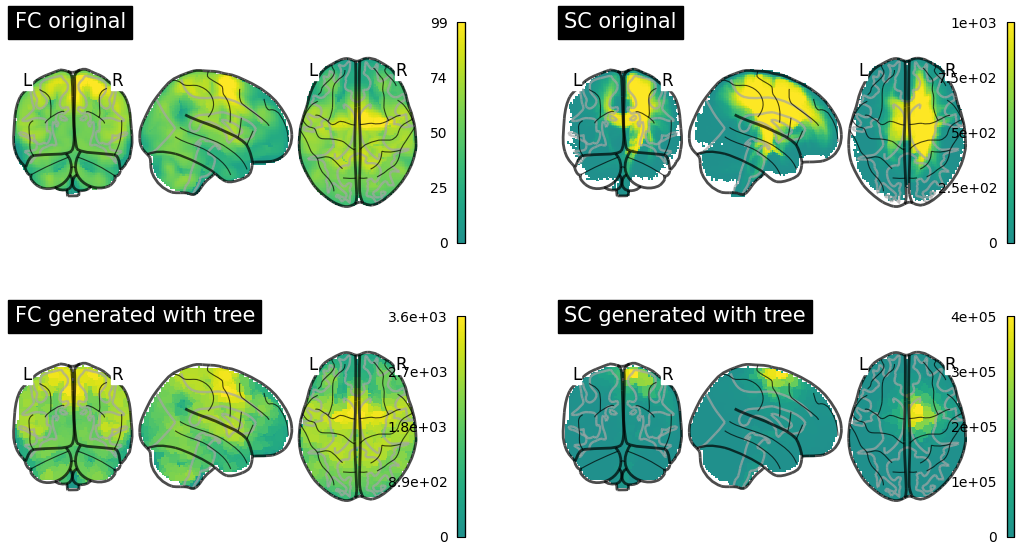

In [11]:
plot, ax = plt.subplots(2, 2, figsize=(13, 7))
fc_map = nib.load("/home/antoniojm/Documents/projects/NetwMAP_CCA/maps/fc/PEL04_fc.nii.gz")
sc_map = nib.load("/home/antoniojm/Documents/projects/NetwMAP_CCA/maps/sc/PEL04_sc.nii.gz")
plotting.plot_glass_brain(fc_map, 
    colorbar = True, axes = ax[0, 0], cmap='viridis', title = "FC original")
plotting.plot_glass_brain(nib.Nifti1Image(fc_conn2atlas, affine=atlas.affine), 
    colorbar = True, axes = ax[1, 0], cmap='viridis', title = "FC generated with tree")
plotting.plot_glass_brain(sc_map, 
    colorbar = True, axes = ax[0, 1], cmap='viridis', title = "SC original")
plotting.plot_glass_brain(nib.Nifti1Image(sc_conn2atlas, affine=atlas.affine), 
    colorbar = True, axes = ax[1, 1], cmap='viridis', title = "SC generated with tree")